<a href="https://colab.research.google.com/github/Abubakrhegazi/Arabic-Grammar-AutoCorrection/blob/main/Arabic-Grammar2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tune AraBERT on Arabic Sentence Correction
This notebook fine-tunes the `aubmindlab/bert-base-arabertv02` model using a binary classification objective (correct vs. incorrect sentences).

In [11]:
!pip install -q transformers datasets arabic-reshaper python-bidi nltk scikit-learn emoji
!pip install numpy==1.26.4


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd
import numpy as np
import torch
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
df = pd.read_csv("/content/drive/MyDrive/Grammar/train.csv")
df = df[['correct', 'incorrect']].dropna()

# Labeling
correct = df[['correct']].copy()
correct['label'] = 1
correct = correct.rename(columns={'correct': 'text'})

incorrect = df[['incorrect']].copy()
incorrect['label'] = 0
incorrect = incorrect.rename(columns={'incorrect': 'text'})

full_df = pd.concat([correct, incorrect], ignore_index=True).sample(n=500, random_state=42).reset_index(drop=True)
full_df = full_df.sample(frac=1).reset_index(drop=True)


In [15]:
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=100)

dataset = Dataset.from_pandas(full_df)
dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Split
dataset = dataset.train_test_split(test_size=0.2)


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [16]:
model = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv02", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [18]:
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs"
)


In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()


<ipython-input-19-c996b84aaad7>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


TrainOutput(global_step=150, training_loss=0.3871077219645182, metrics={'train_runtime': 1643.325, 'train_samples_per_second': 0.73, 'train_steps_per_second': 0.091, 'total_flos': 61666653600000.0, 'train_loss': 0.3871077219645182, 'epoch': 3.0})

In [20]:
predictions = trainer.predict(dataset["test"])
preds = np.argmax(predictions.predictions, axis=1)
print(classification_report(dataset["test"]["labels"], preds))


              precision    recall  f1-score   support

           0       1.00      0.90      0.95        51
           1       0.91      1.00      0.95        49

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



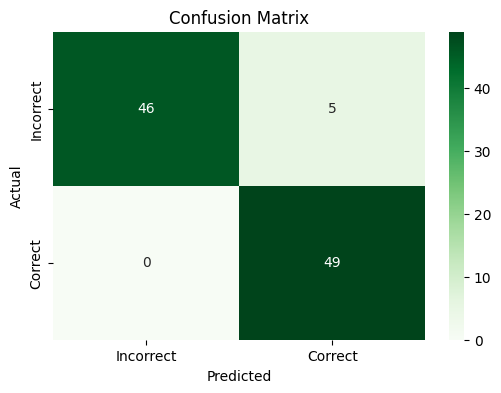

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Incorrect", "Correct"], yticklabels=["Incorrect", "Correct"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_conf_matrix(y_true=dataset["test"]["labels"], y_pred=preds)


# Testing

In [22]:
test_df = pd.read_csv("/content/drive/MyDrive/Grammar/valid.csv")

In [28]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")

def tokenize_function(examples):
    return tokenizer(examples["incorrect"], padding="max_length", truncation=True, max_length=128)


In [29]:
from datasets import Dataset

hf_test = Dataset.from_pandas(test_df)
hf_test = hf_test.map(tokenize_function, batched=True)
hf_test.set_format(type="torch", columns=["input_ids", "attention_mask"])


Map:   0%|          | 0/2293 [00:00<?, ? examples/s]

In [33]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("/content/results/checkpoint-150")  # your fine-tuned model path
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [34]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Create PyTorch tensors
input_ids = torch.tensor(hf_test["input_ids"])
attention_mask = torch.tensor(hf_test["attention_mask"])
loader = DataLoader(TensorDataset(input_ids, attention_mask), batch_size=16)

# Predict
preds = []
with torch.no_grad():
    for input_batch, attn_batch in loader:
        outputs = model(input_ids=input_batch, attention_mask=attn_batch)
        logits = outputs.logits
        batch_preds = torch.argmax(logits, axis=1).cpu().numpy()
        preds.extend(batch_preds)


<ipython-input-34-c7da6fa716ac>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(hf_test["input_ids"])
<ipython-input-34-c7da6fa716ac>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(hf_test["attention_mask"])


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_df["label"], preds))
